In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

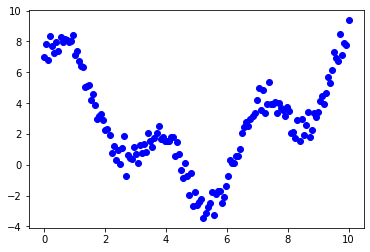

In [2]:
n = 150

X_data = np.linspace(0, 10, n)
X_data = X_data.reshape((n, 1))

Y_data = np.sin(X_data) + 2 * np.sin(2 * X_data) + 0.3 * (X_data - 5) ** 2 
data_no_noise = np.concatenate((X_data, Y_data), axis=1)

Y_data += np.random.normal(0, 0.5, [n, 1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

In [3]:
# divide data into training, validation and test sets

# whether you need to do this and how to do it depends on your problem

# here we have a simple regression problem with a fixed amount of data

data = np.concatenate((X_data, Y_data), axis=1)
data_eval = data.copy()

np.random.shuffle(data)

data_tr, data_val, data_test = np.split(data, [int(0.8*n), int(0.8*n)+int(0.1*n)], axis = 0)
print(data_tr.shape, data_val.shape, data_test.shape)
n_tr, n_val, n_test = data_tr.shape[0], data_val.shape[0], data_test.shape[0]

(120, 2) (15, 2) (15, 2)


In [4]:
# training parameters
learning_rate = 0.01 # optimization step
num_epochs = 6000 # here we do full-batch training, so number of epochs = number of iterations
display_step = 100 # how often we display something while training
wd_par = 0.001 # weight decay (regularization)

# network parameters
n_hidden_1 = 256 # 1st layer, number of neurons
n_hidden_2 = 256 # 2nd layer, number of neurons
num_input = 1 # input dimension
num_output = 1 # output dimension

# tf graph input
X = tf.placeholder(tf.float32, shape = [None, 1]) # how input/output are defined in tensorflow
Y = tf.placeholder(tf.float32, shape = [None, 1])

In [5]:
# store layers weight & bias as dictionaries

# random_normal shows how the weights will be initialized

# in general we use the Xavier initializer (you just divide the standard deviation of the normal dist by some value)

# for each layer we need to give the dimensions

weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])), 
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [6]:
# create model

# here we use the sigmoid activation function

# notice the add and matmul operations that multiply and add weights input/hidden/output units
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer 
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

In [7]:
# tensorflow will read this function each time it wants to do a forward/backward pass
fp = neural_net(X)

# define loss and optimizer

# mean square error plus ell-2 regularization

loss = tf.reduce_mean(tf.square(fp-Y)) \
            + wd_par * tf.reduce_sum([tf.reduce_sum(tf.square(weights[i])) for i in weights])

# Adam optimizer with learning rate as specified in the parameters

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# this has to do with how tensorflow works

# at a high level we have a graph and for everything we want to do we add operations to this graph

# this is a train operation which will be performed at each iteration

train_op = optimizer.minimize(loss)

# initialize the variables

# even though we specified the type of initialization (normal), 
# we need to create an operation that performs the initialization

init = tf.global_variables_initializer()

In [8]:
# for running in Tensorflow 1 we create a session
# in order to run an operation we need the sess.run(operation) command

sess = tf.Session()
sess.run(init)

In [9]:
# in order to run an operation we need to feed it a dictionary
# this dictionary will replace the placeholders we defined above with specific values
# so for training loss we replace with tr data and for validation with val data
# this is the loss even before we start. the loss corresponding to the initial weights
_loss = sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
training_loss = [_loss]
validation_error = [sess.run(loss, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]

print("Epoch:", '%04d' % (0), "loss=", "{:.9f}".format(_loss))

i = 0

tic = time.perf_counter()

for epoch in range(num_epochs):

    sess.run(train_op, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
        
    if (epoch + 1) % display_step == 0:  
        
        _loss = sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
        training_loss.append(_loss)
        validation_error.append(sess.run(loss, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))
        
        print("Epoch:", '%04d' % (epoch + 1), "loss=", "{:.9f}".format(_loss))

toc = time.perf_counter()

print("Optimization Finished!")

Epoch: 0000 loss= 172.653305054
Epoch: 0100 loss= 36.381004333
Epoch: 0200 loss= 24.702764511
Epoch: 0300 loss= 18.924617767
Epoch: 0400 loss= 15.324038506
Epoch: 0500 loss= 12.783264160
Epoch: 0600 loss= 10.872024536
Epoch: 0700 loss= 9.416026115
Epoch: 0800 loss= 8.281032562
Epoch: 0900 loss= 7.292550087
Epoch: 1000 loss= 6.496766090
Epoch: 1100 loss= 5.833623409
Epoch: 1200 loss= 5.259062767
Epoch: 1300 loss= 4.767788410
Epoch: 1400 loss= 4.335829735
Epoch: 1500 loss= 3.954879284
Epoch: 1600 loss= 3.617293835
Epoch: 1700 loss= 3.333353281
Epoch: 1800 loss= 3.069727421
Epoch: 1900 loss= 2.863117695
Epoch: 2000 loss= 2.566720247
Epoch: 2100 loss= 2.378386497
Epoch: 2200 loss= 2.205266476
Epoch: 2300 loss= 2.064144850
Epoch: 2400 loss= 1.973842382
Epoch: 2500 loss= 1.757665277
Epoch: 2600 loss= 1.647164822
Epoch: 2700 loss= 1.544539213
Epoch: 2800 loss= 1.463843107
Epoch: 2900 loss= 1.449790478
Epoch: 3000 loss= 1.281034112
Epoch: 3100 loss= 1.211173892
Epoch: 3200 loss= 1.146505713
Ep

In [10]:
print(f"Run in {toc - tic:0.4f} seconds")

Run in 8.7985 seconds


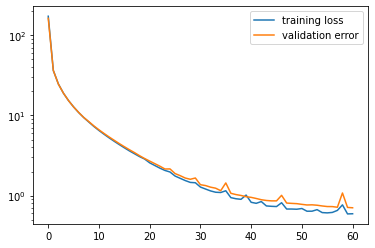

In [11]:
plt.yscale('log')
plt.plot(np.arange(len(training_loss)), training_loss, label = 'training loss')
plt.plot(np.arange(len(training_loss)), validation_error, label = 'validation error')
plt.legend()
plt.show()

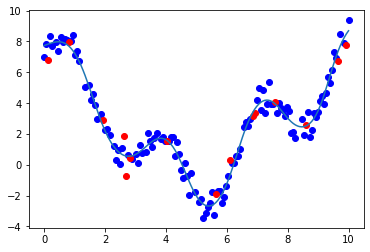

In [12]:
# plot of training, test and evaluation data
# in general we don't have the evaluation data because we don't know the true function

plt.plot(data_tr[:, [0]], data_tr[:, [1]], 'bo')
plt.plot(data_test[:, [0]], data_test[:, [1]], 'ro')
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}))
plt.show()

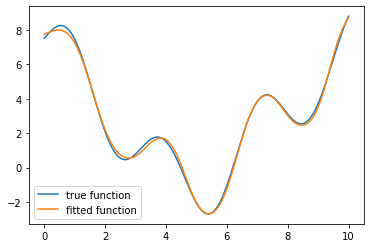

In [13]:
plt.plot(data_no_noise[:, [0]], data_no_noise[:, [1]], label = 'true function')
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'fitted function')
plt.legend()
plt.show()